Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
shape of x_train: (5421, 28, 28), y_train: (5421,)


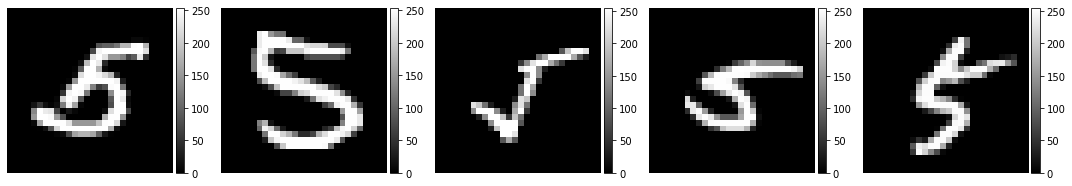

training maximum value 1.0


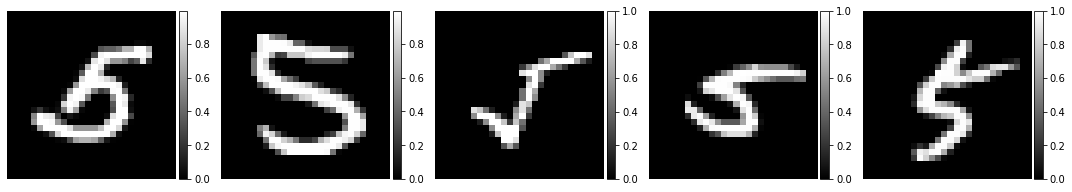

shape of training data (4421, 32, 32)


In [4]:
!pip install voxelmorph 

# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

# You should most often have this import together with all other imports at the top, 
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist

# load MNIST data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

In [5]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)
displacement tensor: (None, 32, 32, 2)


In [6]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

In [7]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

In [8]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


In [9]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

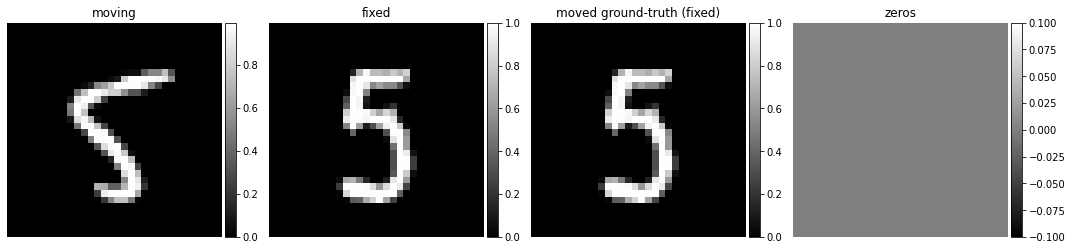

In [10]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [51]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


100/100 - 35s - loss: 0.0165 - vxm_dense_transformer_loss: 0.0117 - vxm_dense_flow_loss: 0.0956 - 35s/epoch - 354ms/step
Epoch 2/10
100/100 - 35s - loss: 0.0151 - vxm_dense_transformer_loss: 0.0104 - vxm_dense_flow_loss: 0.0950 - 35s/epoch - 346ms/step
Epoch 3/10
100/100 - 34s - loss: 0.0138 - vxm_dense_transformer_loss: 0.0092 - vxm_dense_flow_loss: 0.0920 - 34s/epoch - 345ms/step
Epoch 4/10
100/100 - 34s - loss: 0.0127 - vxm_dense_transformer_loss: 0.0083 - vxm_dense_flow_loss: 0.0883 - 34s/epoch - 345ms/step
Epoch 5/10
100/100 - 34s - loss: 0.0124 - vxm_dense_transformer_loss: 0.0080 - vxm_dense_flow_loss: 0.0881 - 34s/epoch - 343ms/step
Epoch 6/10
100/100 - 35s - loss: 0.0115 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 0.0855 - 35s/epoch - 345ms/step
Epoch 7/10
100/100 - 34s - loss: 0.0112 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 0.0856 - 34s/epoch - 344ms/step
Epoch 8/10
100/100 - 35s - loss: 0.0109 - vxm_dense_transformer_loss: 0.0066 - vxm_dens

In [139]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

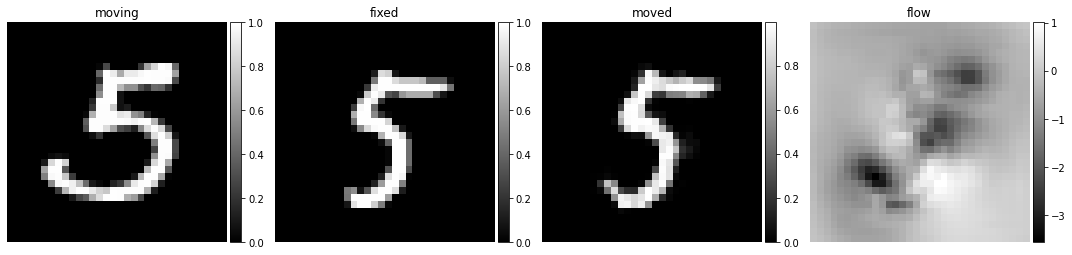

In [140]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, axes_off = False);

In [156]:
moving = val_input[0]
fixed  = val_input[1]
moved  = val_pred[0]
flow   = val_pred[1]

print("flow.shape  : {}".format(flow.shape))
print("moving.shape: {}".format(moving.shape))
print("fixed.shape : {}".format(fixed.shape))

mv_x = 14
fx_x = 14

print("moving:")
print(moving[0, mv_x, :, 0])
print("fixed:")
print(fixed[0, fx_x, :, 0])

flow.shape  : (1, 32, 32, 2)
moving.shape: (1, 32, 32, 1)
fixed.shape : (1, 32, 32, 1)
moving:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.36862745
 0.99215686 0.99215686 0.99215686 0.99607843 0.99215686 0.98039216
 0.94901961 0.99215686 0.99607843 0.71764706 0.21568627 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
fixed:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.47058824
 0.99607843 0.99607843 0.99607843 0.99607843 0.83529412 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [157]:
mv_y = 12
fx_y = 12

print("moving:")
print(moving[0, mv_x, mv_y, 0])
print("fixed:")
print(fixed[0, fx_x, fx_y, 0])

flow_x = flow[0, mv_x, mv_y, 0]
flow_y = flow[0, mv_x, mv_y, 1]
print("flow.x: {}".format(flow_x))
print("flow.y: {}".format(flow_y))

moving:
0.9921568627450981
fixed:
0.996078431372549
flow.x: -0.08608479797840118
flow.y: 0.5397959351539612


In [159]:
pred_fx_x = mv_x - int(flow_x)
pred_fx_y = mv_y - int(flow_y)

print("pred_fx_x: {}, fx_x: {}".format(pred_fx_x, fx_x))
print("pred_fx_y: {}, fx_y: {}".format(pred_fx_y, fx_y))

pred_fx_x: 14, fx_x: 14
pred_fx_y: 12, fx_y: 12


# MRI Brain

--2022-09-08 14:22:21--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.1.43
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.1.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16644702 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  6.31MB/s    in 2.5s    

2022-09-08 14:22:25 (6.31 MB/s) - ‘data.tar.gz’ saved [16644702/16644702]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
fs_rgb.npy
subj1.npz
subj2.npz
tutorial_data.npz
train shape: (208, 192, 160)


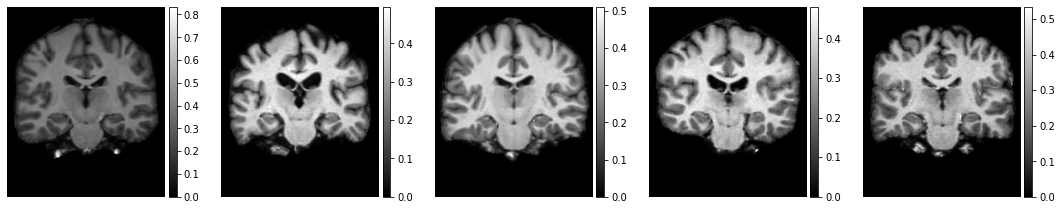

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


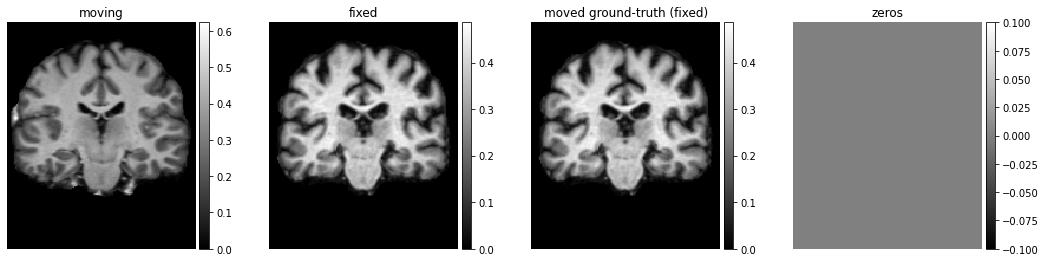

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


5/5 - 15s - loss: 0.0074 - vxm_dense_transformer_loss: 0.0074 - vxm_dense_flow_loss: 8.6269e-08 - 15s/epoch - 3s/step
Epoch 2/5
5/5 - 12s - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 9.9504e-07 - 12s/epoch - 2s/step
Epoch 3/5
5/5 - 12s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0067 - vxm_dense_flow_loss: 4.8537e-06 - 12s/epoch - 2s/step
Epoch 4/5
5/5 - 12s - loss: 0.0067 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 1.9281e-05 - 12s/epoch - 2s/step
Epoch 5/5
5/5 - 12s - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 5.9380e-05 - 12s/epoch - 2s/step


In [160]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

In [161]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

In [162]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [163]:
# prediction
val_pred = vxm_model.predict(val_input)

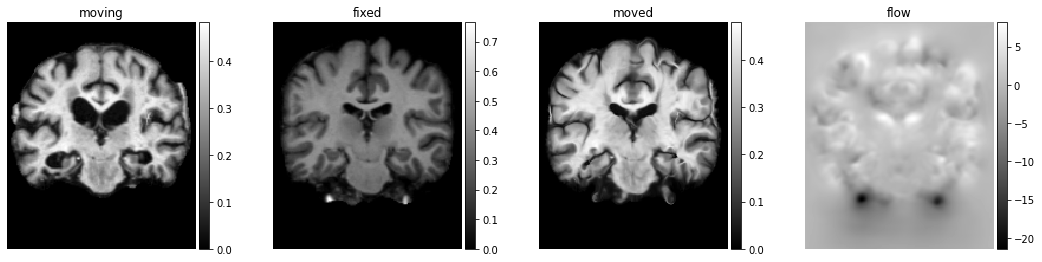

In [167]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [207]:
import cv2
moving = val_input[0]
cv2.imwrite("/content/moving.tif", moving[0,:,:,0])

True

In [210]:
np.savez("/content/moving.npz", vol=moving)

In [213]:
fixed = val_input[1]
np.savez("/content/fixed.npz", vol=fixed)

In [220]:
moved = val_pred[0]
np.savez("/content/moved.npz", vol=moved)

In [214]:
moving.shape

(1, 192, 160, 1)

In [215]:
moving[0,80,77,0]

0.09803921568627451

In [217]:
flow = val_pred[1]
flow.shape

(1, 192, 160, 2)

In [223]:
flow_x = flow[0,80,105,0]
flow_y = flow[0,80,105,1]

In [224]:
print(flow_x)
print(flow_y)

-0.99463254
1.4527185


In [236]:
moving_x = 79
moving_y = 104

In [242]:
moving[0,moving_x,moving_y,0]*255

flow_x = flow[0,moving_x,moving_y,0]
flow_y = flow[0,moving_x,moving_y,1]
print(flow_x)
print(flow_y)
print("int")
print(round(flow_x))
print(round(flow_y))

0.94631505
2.8727949
int
1
3


In [243]:
moved_x = moving_x - int(flow_x)
moved_y = moving_y - int(flow_y)
print(moved_x)
print(moved_y)

79
102


In [268]:
x = np.array([79,78,62,87,98,65,93])
y = np.array([104,79,133,144,132,55,57])

expected_x = np.array([79,78,61,87,97,65,94])
expected_y = np.array([101,77,133,145,134,54,55])

num = 7
print("Pixel locations")
for i in range(num-2):
  flow_x = round(flow[0,x[i], y[i], 0])
  flow_y = round(flow[0,x[i], y[i], 1])

  moved_x = x[i] - flow_x
  moved_y = y[i] - flow_y
  print("cp_select: ({}, {}),\t deformation_field: ({}, {})".format(expected_x[i], expected_y[i], moved_x, moved_y))

Pixel locations
cp_select: (79, 101),	 deformation_field: (78, 101)
cp_select: (78, 77),	 deformation_field: (79, 78)
cp_select: (61, 133),	 deformation_field: (59, 133)
cp_select: (87, 145),	 deformation_field: (84, 143)
cp_select: (97, 134),	 deformation_field: (95, 131)


In [257]:
moving[0,79,104,0]*255

81.0